In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

Our dataset contains timestamped blood-glucose levels. Still need to finish implementing a column for rate of change(Was guided to look into five point stencils for first/second order derivatives - have looked into them but have a few questions on implementation here). Did a bit of preprocessing(mainly trying to round to even numbers(the readings are not all at the same times during the day, therefore grouping by them becomes a nuisance) and looking over the general spread of the data. 

In [380]:
df = pd.read_csv('./data/12-3l-21_to_3-30-22.csv',skiprows=[x for x in range(1, 12)],)
df = df.iloc[:,[1, 2, 7]]
df = df[df.isin(['Low', 'High']) == False]
df = df[df.iloc[:,2].notna()]
dfM = df.reset_index(drop=True)
dfM = dfM.astype({dfM.columns[2]:'float64'})
dfM.head(10)

,Timestamp (YYYY-MM-DDThh:mm:ss),Event Type,Glucose Value (mg/dL)
0,2021-12-31T00:00:48,EGV,158.0
1,2021-12-31T00:05:48,EGV,158.0
2,2021-12-31T00:10:49,EGV,157.0
3,2021-12-31T00:15:48,EGV,149.0
4,2021-12-31T00:20:48,EGV,143.0
5,2021-12-31T00:25:48,EGV,135.0
6,2021-12-31T00:30:48,EGV,139.0
7,2021-12-31T00:35:49,EGV,142.0
8,2021-12-31T00:40:49,EGV,146.0
9,2021-12-31T00:45:48,EGV,145.0


In [381]:
gluc = dfM.iloc[:,2]
gluc.describe()

count    25016.000000
mean       186.106132
std         57.167021
min         44.000000
25%        145.000000
50%        182.000000
75%        223.000000
max        395.000000
Name: Glucose Value (mg/dL), dtype: float64

In [382]:
dfM[['MM-DD', 'HH:MM']] = dfM.iloc[:,0].str.split('T', 1, expand=True)
dfM.drop('Timestamp (YYYY-MM-DDThh:mm:ss)', axis=1, inplace=True)
dfM[['MM-DD', 'HH:MM']]

,MM-DD,HH:MM
0,2021-12-31,00:00:48
1,2021-12-31,00:05:48
2,2021-12-31,00:10:49
3,2021-12-31,00:15:48
4,2021-12-31,00:20:48
...,...,...
25011,2022-03-30,12:02:04
25012,2022-03-30,12:07:04
25013,2022-03-30,12:12:04
25014,2022-03-30,12:17:03


In [383]:
round_5 = lambda x: '0' + str(x - x % 5)
round_5(8)

'05'

In [384]:
dfM['HH:MM'] = dfM['HH:MM'].str.slice(start=0, stop=5)
dfM['MM-DD'] = dfM['MM-DD'].str.slice(start=5)
dfM['HH:MM'] = dfM['HH:MM'].apply(lambda x: x[0:3] + str(round_5(int(x[3:5]))[-2:])) 
#this is strictly unneccesarily complicated :shrugs:
dfM['HH:MM'].unique()

array(['00:00', '00:05', '00:10', '00:15', '00:20', '00:25', '00:30',
       '00:35', '00:40', '00:45', '00:50', '00:55', '01:00', '01:05',
       '01:10', '01:15', '01:20', '01:25', '01:30', '01:35', '01:40',
       '01:45', '01:50', '01:55', '02:00', '02:05', '02:10', '02:15',
       '02:20', '02:25', '02:30', '02:35', '02:40', '02:45', '02:50',
       '02:55', '03:00', '03:05', '03:10', '03:15', '03:20', '03:25',
       '03:30', '03:35', '03:40', '03:45', '03:50', '03:55', '04:00',
       '04:05', '04:10', '04:15', '04:20', '04:25', '04:30', '04:35',
       '04:40', '04:45', '04:50', '04:55', '05:00', '05:05', '05:10',
       '05:15', '05:20', '05:25', '05:30', '05:35', '05:40', '05:45',
       '05:50', '05:55', '06:00', '06:05', '06:10', '06:15', '06:20',
       '06:25', '06:30', '06:35', '06:40', '06:45', '06:50', '06:55',
       '07:00', '07:05', '07:10', '07:15', '07:20', '07:25', '07:30',
       '07:35', '07:40', '07:45', '07:50', '07:55', '08:00', '08:05',
       '08:10', '08:

In [385]:
means = dfM.groupby(['HH:MM'], as_index=False).mean().to_numpy().T
means[:,:10]

array([['00:00', '00:05', '00:10', '00:15', '00:20', '00:25', '00:30',
        '00:35', '00:40', '00:45'],
       [194.80459770114942, 193.64772727272728, 191.816091954023,
        193.26436781609195, 193.63636363636363, 193.26136363636363,
        191.367816091954, 190.67045454545453, 189.79545454545453,
        188.67816091954023]], dtype=object)

Text(0.5, 0, 'Mintues')

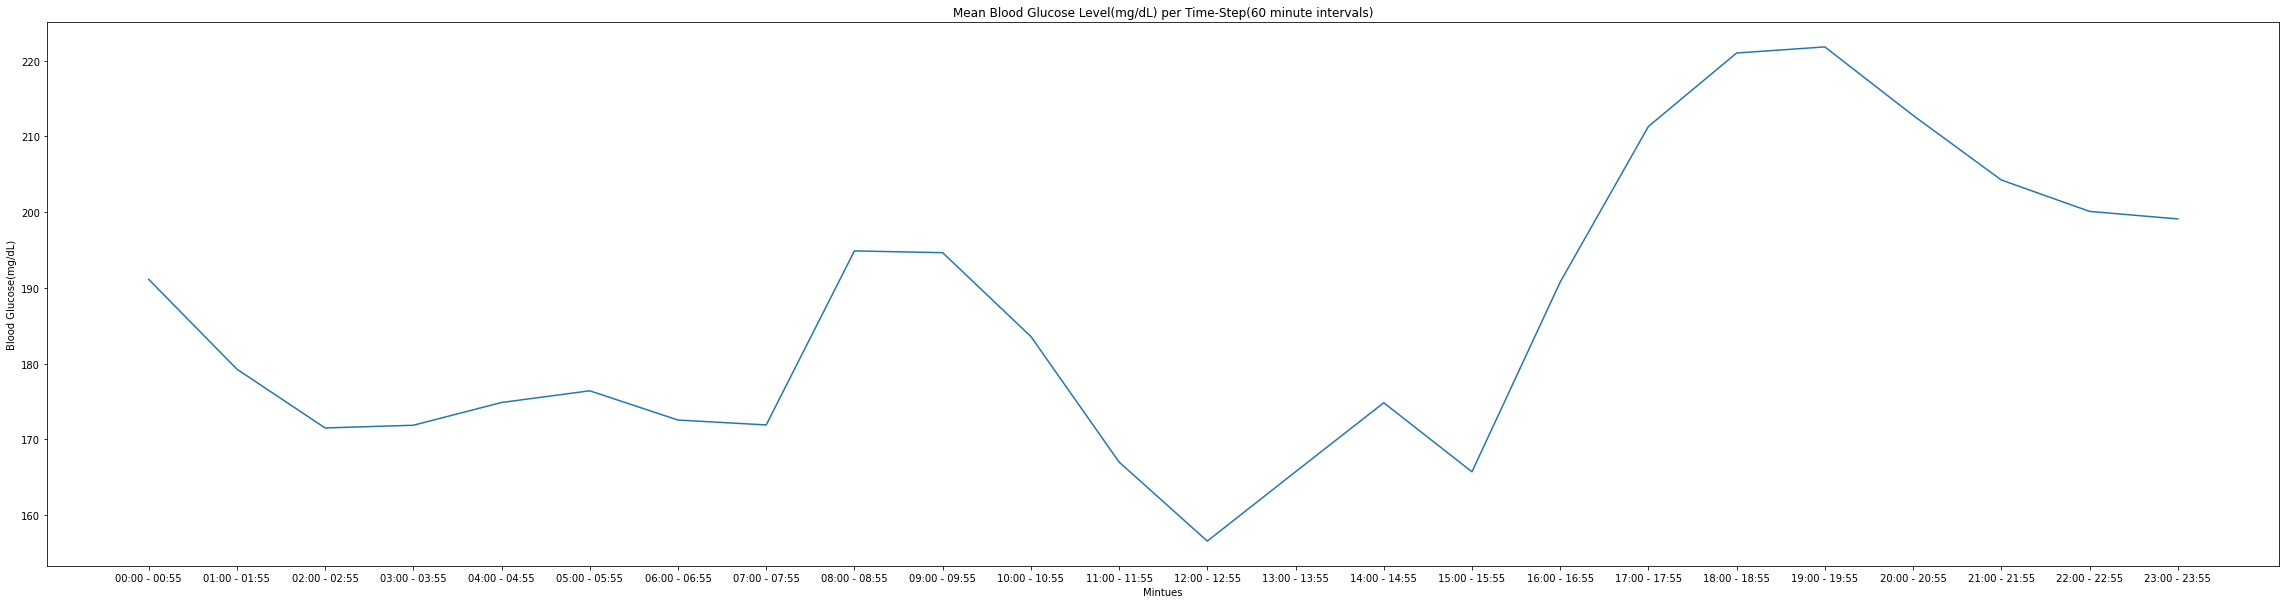

In [386]:
plotted_means = [[] for _ in [0,1]]
stepsize = 12
for x in range(0, len(means[0]), stepsize):
    plotted_means[1].append(np.sum(means[1][x:x+stepsize])/stepsize)
    plotted_means[0].append(means[0][x] + " - " + means[0][x+stepsize-1])
fig, ax = plt.subplots(figsize=[40,10])
ax.plot(plotted_means[0], plotted_means[1])
ax.set_title("Mean Blood Glucose Level(mg/dL) per Time-Step(60 minute intervals)")
ax.set_ylabel("Blood Glucose(mg/dL)")
ax.set_xlabel("Mintues")

Here is the definition of the five point stencil first derivative approx. and second derivative approx. 

We have five points separated by h(our timestep of 5 here):

{x - 2h, x - h, x, x + h, x + 2h}

![f'(x)](firstd.png)

![f'(x)](secondd.png)
Taken from Wikipedia - https://en.wikipedia.org/wiki/Fivepoint_stencil#:~:text=In%20numerical%20analysis%2C%20given%20a,to%20derivatives%20at%20grid%20points

In [387]:
firstd = lambda x,h: sum(x*np.array([1,-8,8,-1]))/(12*h) 
secondd = lambda x,h: sum(x*np.array([-1,16,-30,16,-1]))/(12*(h**2))
#I'm not sure how to apply this for the last two and the first two endpoints - I'm going to assume that it makes sense 
#use a left centered/right-centered finite derivative for my boundaries. Need to check.
h = 5
fda = np.zeros((len(gluc), 2))
for x in range(2, len(gluc)-2):
    fda[x] = firstd([*gluc[x-2:x], *gluc[x+1:x+3]],h), secondd(gluc[x-2:x+3],h)
dfA = pd.concat([dfM, pd.DataFrame(fda, columns = ["f_prime(x)", 'f_prime_prime(x)'])], axis=1)

In [388]:
#lets normalize our data so it is all on the same scale.
x = dfA.iloc[:,1]
maxx, minx = x.max(), x.min()
dfA['bglNorm'] = x.apply(lambda x: (x - minx) / (maxx - minx))

In [389]:
euc_dist = lambda x,y: np.sqrt(np.sum((x-y)**2))

We want to assign points to a label given stdevs away from mean -> do regression and predict what the next value will be. We will do this with a knn-like approach where we will take the closest values and average the mean rate of change + do value * mean rate + value to return what our predicted value would be.

In [390]:
#lets split our data into 6 chunks. Increasing quickly, increasing rapidly, decreasing quickly, decreasing rapidly
#constant decreasing(within -0.5 stdev), constant increasing(within 0.5 stdev)
def split(v, s=stdevs[1]):
    if v > 2*s: #2stdevs on the right
        return 0
    elif v > s: #one stdev on the right
        return 1
    elif v > 0: #within one stdev on right
        return 2
    elif v > -s: #within one stdev on left.
        return 3
    elif v > -2*s: #1-2 stdev on left
        return 4
    else: #2 stdev on right
        return 5
#just added 1he here. Rewarding choosing the same label to a very very large level here(in terms of minimizing
#euclidean distance).
dfA['Tag'] = dfA.iloc[:,4].apply(lambda x: split(x))

Time series data requires us to convert our feature into a coupling of features when trying to use euclidean distance:

Namely we need to center our data around cosine and sine. This is due to the problem of time being circular.

https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

In [391]:
def center(v):
    z = int(v[0:2])*60 + int(v[3:])
    x = 2 * np.pi * z / 1435 # 1435 -> 23:55
    cosx = np.cos(x)
    sinx = np.sin(x)
    return cosx, sinx

x= dfA.loc[:,'HH:MM'].apply(lambda x: np.array(center(x)))
dfA[['cosx', 'sinx']] = pd.DataFrame(x.to_list(),index=dfA.index)

In [392]:
dfA

,Event Type,Glucose Value (mg/dL),MM-DD,HH:MM,f_prime(x),f_prime_prime(x),bglNorm,Tag,cosx,sinx
0,EGV,158.0,12-31,00:00,0.000000,0.000000,0.324786,3,1.000000,0.000000
1,EGV,158.0,12-31,00:05,0.000000,0.000000,0.324786,3,0.999760,0.021891
2,EGV,157.0,12-31,00:10,-0.950000,-0.330000,0.321937,3,0.999042,0.043771
3,EGV,149.0,12-31,00:15,-1.483333,0.123333,0.299145,4,0.997844,0.065631
4,EGV,143.0,12-31,00:20,-1.566667,-0.140000,0.282051,4,0.996168,0.087459
...,...,...,...,...,...,...,...,...,...,...
25011,EGV,141.0,03-30,12:00,-0.233333,0.013333,0.276353,3,-0.999940,-0.010946
25012,EGV,140.0,03-30,12:05,-0.283333,-0.043333,0.273504,3,-0.999461,-0.032833
25013,EGV,138.0,03-30,12:10,-0.516667,-0.043333,0.267806,3,-0.998503,-0.054704
25014,EGV,135.0,03-30,12:15,0.000000,0.000000,0.259259,3,-0.997066,-0.076549
